In [1]:
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from random import randint
import glob

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [4]:
def getData(fileName):
    data_folders = [
    os.path.join(fileName, d) for d in sorted(os.listdir(fileName))
    if os.path.isdir(os.path.join(fileName, d))]
    if len(data_folders) != 10:
        raise Exception(
            'Expected %d folders, one per class. Found %d instead.' % (
            10, len(data_folders)))
    print(data_folders)
    return data_folders
train_folders = getData("notMNIST_large")
test_folders = getData("notMNIST_small")

['notMNIST_large\\A', 'notMNIST_large\\B', 'notMNIST_large\\C', 'notMNIST_large\\D', 'notMNIST_large\\E', 'notMNIST_large\\F', 'notMNIST_large\\G', 'notMNIST_large\\H', 'notMNIST_large\\I', 'notMNIST_large\\J']
['notMNIST_small\\A', 'notMNIST_small\\B', 'notMNIST_small\\C', 'notMNIST_small\\D', 'notMNIST_small\\E', 'notMNIST_small\\F', 'notMNIST_small\\G', 'notMNIST_small\\H', 'notMNIST_small\\I', 'notMNIST_small\\J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

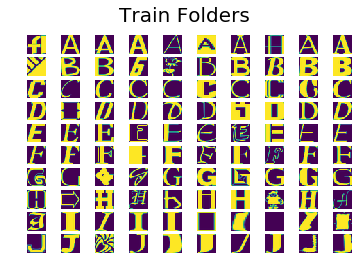

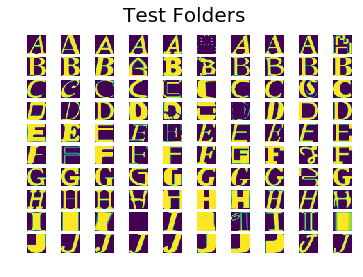

In [8]:
import random
import matplotlib.image as mpimg

def drawSampleImgs(dataFolder,noOfImgs,title=None):
    fig = plt.figure()
    if title:
        fig.suptitle(title, fontsize=20)
    for fIndex,folder in enumerate(dataFolder):
        imgs = os.listdir(folder)
        sampleImgs = random.sample(imgs,noOfImgs)
        for iIndex,i in enumerate(sampleImgs):
            image = os.path.join(folder,i)
            axes = fig.add_subplot(len(dataFolder),noOfImgs, noOfImgs*fIndex+iIndex+1)
            axes.imshow(mpimg.imread(image))
            axes.set_axis_off()
    plt.show()

drawSampleImgs(train_folders, 10, 'Train Folders')
drawSampleImgs(test_folders, 10, 'Test Folders')

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [11]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large\A.pickle already present - Skipping pickling.
notMNIST_large\B.pickle already present - Skipping pickling.
notMNIST_large\C.pickle already present - Skipping pickling.
notMNIST_large\D.pickle already present - Skipping pickling.
notMNIST_large\E.pickle already present - Skipping pickling.
notMNIST_large\F.pickle already present - Skipping pickling.
notMNIST_large\G.pickle already present - Skipping pickling.
notMNIST_large\H.pickle already present - Skipping pickling.
notMNIST_large\I.pickle already present - Skipping pickling.
notMNIST_large\J.pickle already present - Skipping pickling.
notMNIST_small\A.pickle already present - Skipping pickling.
notMNIST_small\B.pickle already present - Skipping pickling.
notMNIST_small\C.pickle already present - Skipping pickling.
notMNIST_small\D.pickle already present - Skipping pickling.
notMNIST_small\E.pickle already present - Skipping pickling.
notMNIST_small\F.pickle already present - Skipping pickling.
notMNIST_small\G.pickle 

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

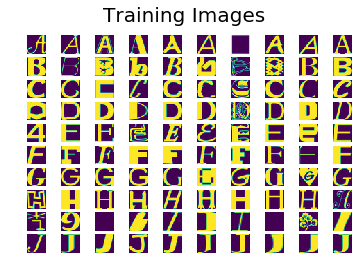

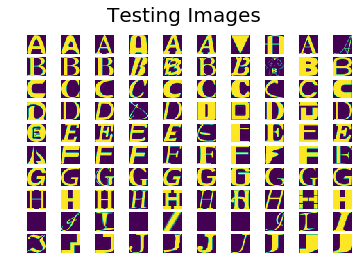

In [40]:
def peakPickle(dataFolder,noOfImgs,title=None):
    fig = plt.figure()
    if title:
        fig.suptitle(title, fontsize=20)
    for fIndex,folder in enumerate(dataFolder):
        try:
            with open(folder, "rb") as f:
                imgs = pickle.load(f)
                sampleImgs = imgs[np.random.randint(imgs.shape[0], size=10), :]
                for iIndex,i in enumerate(sampleImgs):
                    axes = fig.add_subplot(len(dataFolder),noOfImgs, noOfImgs*fIndex+iIndex+1)
                    axes.imshow(i)
                    axes.set_axis_off()
        except Exception as e:
            print('Unable to process data from', dataFolder, ':', e)
            raise
    plt.show()
        
peakPickle(train_datasets,10,"Training Images")
peakPickle(test_datasets,10,"Testing Images")

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [20]:
def checkMeanError(data):
    mean = sum(data)/len(data)
    for i in data:
        if abs(i - mean) > 0.1*mean:
            print("Mean Error too large")
        else:
            print("data looks good")

def checkPickle(dataset):
    lenPickle = []
    index = 0
    for folder in dataset:
        try:
            with open(folder, "rb") as f:
                lenPickle.append(len(pickle.load(f)))
                print(folder," ",lenPickle[index])
                index+=1
        except Exception as e:
            print('Unable to process data from', dataset, ':', e)
            raise
    checkMeanError(lenPickle)
checkPickle(train_datasets)
checkPickle(test_datasets)

notMNIST_large\A.pickle   52909
notMNIST_large\B.pickle   52911
notMNIST_large\C.pickle   52912
notMNIST_large\D.pickle   52911
notMNIST_large\E.pickle   52912
notMNIST_large\F.pickle   52912
notMNIST_large\G.pickle   52912
notMNIST_large\H.pickle   52912
notMNIST_large\I.pickle   52912
notMNIST_large\J.pickle   52911
data looks good
data looks good
data looks good
data looks good
data looks good
data looks good
data looks good
data looks good
data looks good
data looks good
notMNIST_small\A.pickle   1872
notMNIST_small\B.pickle   1873
notMNIST_small\C.pickle   1873
notMNIST_small\D.pickle   1873
notMNIST_small\E.pickle   1873
notMNIST_small\F.pickle   1872
notMNIST_small\G.pickle   1872
notMNIST_small\H.pickle   1872
notMNIST_small\I.pickle   1872
notMNIST_small\J.pickle   1872
data looks good
data looks good
data looks good
data looks good
data looks good
data looks good
data looks good
data looks good
data looks good
data looks good


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [41]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [42]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

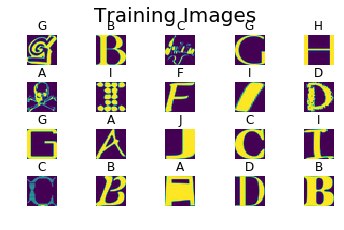

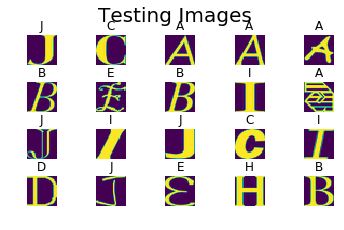

In [73]:

def isGoodAfterShuffle(dataSet,labels,title=None):
    fig = plt.figure()
    if title:
        fig.suptitle(title, fontsize=20)
    sample = random.sample(range(len(labels)),20)
    for index,item in enumerate(sample):
        ax = fig.add_subplot(5, 5, index + 1)
        ax.set_axis_off()
        ax.set_title(chr(ord('A') + labels[item]))
        ax.imshow(dataSet[item])
    plt.subplots_adjust(hspace=0.6)
    plt.show()
        
isGoodAfterShuffle(train_dataset,train_labels,"Training Images")
isGoodAfterShuffle(test_dataset,test_labels,"Testing Images")

# for i in range(10):
#     rand_no = randint(0,200000)
#     plt.title(train_labels[rand_no])
#     plt.imshow(train_dataset[rand_no])
#     plt.show()

Finally, let's save the data for later reuse:

In [74]:
pickle_file = os.path.join('./', 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [75]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---


In [90]:
import hashlib

def extract_overlap_hash_where(dataset_1, dataset_2):
    dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
    dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
    overlap = {}
    for i, hash1 in enumerate(dataset_hash_1):
        duplicates = np.where(dataset_hash_2 == hash1)
        if len(duplicates[0]):
            overlap[i] = duplicates[0]
    return overlap

#optimized to not to calculate overlaps again
def sanitize(dataset_1, overlap, labels_1):
    return np.delete(dataset_1, overlap, 0), np.delete(labels_1, overlap, None)


overlap_test_train = extract_overlap_hash_where(test_dataset, train_dataset)
print('Number of overlaps:', len(overlap_test_train.keys()))
test_dataset_sanit, test_labels_sanit = sanitize(test_dataset, list(overlap_test_train.keys()), test_labels)
print('Overlapping images removed from test_dataset: ', len(test_dataset) - len(test_dataset_sanit))

overlap_valid_train = extract_overlap_hash_where(valid_dataset, train_dataset)
valid_dataset_sanit, valid_labels_sanit = sanitize(valid_dataset, list(overlap_valid_train.keys()), valid_labels)
print('Overlapping images removed from valid_dataset: ', len(valid_dataset) - len(valid_dataset_sanit))

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_labels_sanit.shape, valid_labels_sanit.shape)
print('Testing:', test_dataset_sanit.shape, test_labels_sanit.shape)
pickle_file_sanit = 'notMNIST_sanit.pickle'

try:
    f = open(pickle_file_sanit, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset_sanit,
        'valid_labels': valid_labels_sanit,
        'test_dataset': test_dataset_sanit,
        'test_labels': test_labels_sanit,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

statinfo = os.stat(pickle_file_sanit)
print('Compressed pickle size:', statinfo.st_size)


Number of overlaps: 1244
Overlapping images removed from test_dataset:  1244
Overlapping images removed from valid_dataset:  1076
Training: (200000, 28, 28) (200000,)
Validation: (8924,) (8924,)
Testing: (8756, 28, 28) (8756,)
Compressed pickle size: 683515706


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [89]:
sampleSize = [50,100,1000,5000]
for sample in sampleSize:
    lgr = LogisticRegression()
    X_train = train_dataset[:sample].reshape(sample,28*28)
    y_train = train_labels[:sample]
    lgr.fit(X_train,y_train)
    X_test = test_dataset.reshape(test_dataset.shape[0],28*28)
    y_test = test_labels
    predictions = lgr.predict(X_test)
    accuracy = lgr.score(X_test, y_test)
    print("Sample Size: ",sample,"\t Accuracy: ",accuracy)

Sample Size:  50 	 Accuracy:  0.6207
Sample Size:  100 	 Accuracy:  0.7263
Sample Size:  1000 	 Accuracy:  0.84
Sample Size:  5000 	 Accuracy:  0.8529
